In [2]:
!pip install git+https://github.com/firekind/athena
# ! pip install git+https://github.com/firekind/athena > /dev/null

  Cloning https://github.com/firekind/athena to /tmp/pip-req-build-5enpwhij
  Running command git clone -q https://github.com/firekind/athena /tmp/pip-req-build-5enpwhij
  Created wheel for athena: filename=athena-0.0.2-cp36-none-any.whl size=48787 sha256=10495374dfb5eb07464a3d10fc3a65cf201ca084b157eab3f979f3e7f1ee7e1d
  Stored in directory: /tmp/pip-ephem-wheel-cache-6r88ilby/wheels/36/d3/7b/d9500a9af2498abc5d48d60c7db37c1456ee745049da352e0b
Successfully built athena


In [3]:
import torch.optim as optim
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import albumentations as A
from albumentations.pytorch.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR, OneCycleLR, ReduceLROnPlateau

from athena import datasets, Experiment, Experiments, ClassificationSolver
from athena.visualizations import plot_misclassified, plot_scalars
from athena.utils.transforms import ToNumpy, ToTensor
from athena.models import ResNet18
from athena.tuning import lr_finder

In [4]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

batch_size = 512
epochs = 50

In [7]:
train_set = datasets.tinyimagenet(root='.', download=True, use_default_transforms=True)
test_set = datasets.tinyimagenet(root='.', train=False, download=True, use_default_transforms=True)

Extracting ./tiny-imagenet-200.zip to .

Using downloaded and verified file: ./tiny-imagenet-200.zip
Extracting ./tiny-imagenet-200.zip to .


In [8]:
train_load, valid_load = datasets.train_val_split(batch_size, train_set, val_split=0.3)

In [9]:
images, labels = next(iter(train_load))

print(images.shape)
print(labels.shape)

torch.Size([512, 3, 64, 64])
torch.Size([512])


In [9]:
from athena.tuning import lr_finder

# def acc_fn(outputs, labels):
#     pred = outputs.argmax(dim=1, keepdim=True)
#     correct = pred.eq(labels.view_as(pred)).float()
#     return correct.mean()
  

optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)
criterion = F.cross_entropy

lr_finder = lr_finder.LRFinder(net, optimizer, criterion, device=device)

# Starting range test
lr_finder.reset()
lr_finder.range_test(train_load, val_loader=valid_load, end_lr=1e-2, num_iter=100, step_mode="linear")
res = lr_finder.plot(mode="acc")

Running LR Finder:
100/100 [==============================] - 3915s 39s/step


ValueError: ignored

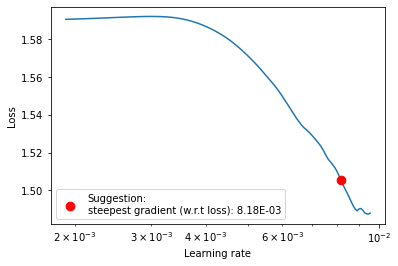

In [10]:
res = lr_finder.plot()

In [14]:
# creating the experiment
exp = (
    Experiment.builder()
    .props()
      .name("Tiny Imagenet Exp")
      .log_directory(".")
    .data()
      .train_loader(train_load)
      .val_loader(valid_load)
    .solver(ClassificationSolver)
      .model(ResNet18(200))
      .optimizer(optim.SGD, lr=0.008, momentum=0.9)
      .epochs(epochs)
    .build() 
)

In [15]:
exp.fit_one_cycle(max_lr=8.18e-3, max_at_epoch=10, anneal_strategy="linear")

=> Running experiment: Tiny Imagenet Exp
Epoch: 1 / 50
137/137 [==============================] - 140s 1s/step - loss: 4.8930 - train accuracy: 0.0301
Validation set: validation loss: 4.8532, validation accuracy: 0.0491

Epoch: 2 / 50
137/137 [==============================] - 140s 1s/step - loss: 4.4690 - train accuracy: 0.0701
Validation set: validation loss: 4.5079, validation accuracy: 0.0805

Epoch: 3 / 50
137/137 [==============================] - 140s 1s/step - loss: 4.1430 - train accuracy: 0.1119
Validation set: validation loss: 4.2140, validation accuracy: 0.1155

Epoch: 4 / 50
137/137 [==============================] - 139s 1s/step - loss: 3.8770 - train accuracy: 0.1488
Validation set: validation loss: 4.0930, validation accuracy: 0.1264

Epoch: 5 / 50
137/137 [==============================] - 139s 1s/step - loss: 3.6830 - train accuracy: 0.1793
Validation set: validation loss: 3.8946, validation accuracy: 0.1537

Epoch: 6 / 50
137/137 [==============================] - 13

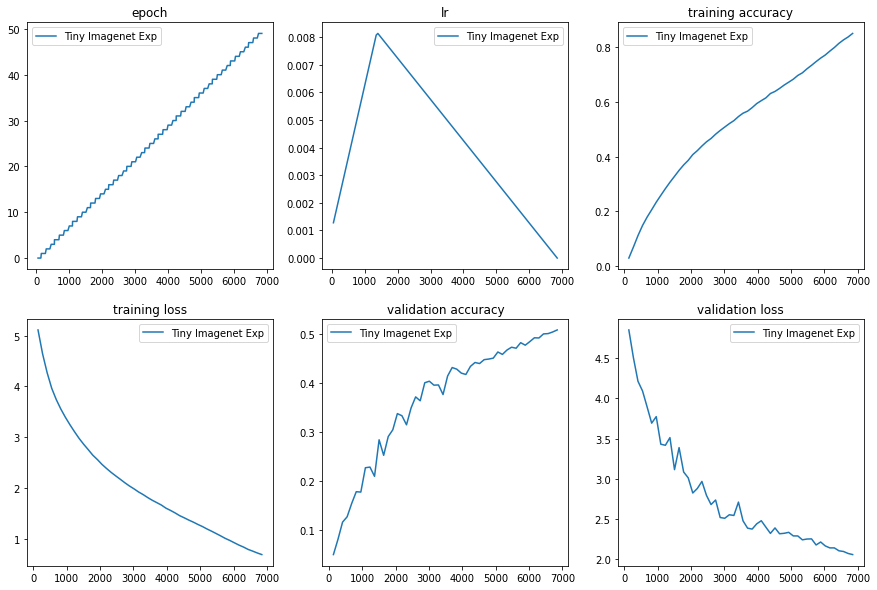

In [18]:
exp.plot_scalars()